In [19]:
from ftplib import FTP
import os
import tempfile
import urllib

import numpy as np
import pandas as pd
import richdem as rd
import geopandas as gpd
from glob import glob
from osgeo import osr, gdal
import rasterstats as rs
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import colors
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1 import make_axes_locatable
import rasterio as rio
from rasterio.merge import merge
from rasterio.mask import mask
from rasterio.plot import plotting_extent, show
from shapely.geometry import mapping, box, Point, Polygon
from descartes.patch import PolygonPatch
import shapefile
from linecache import getline

import earthpy as et
import earthpy.spatial as es
import earthpy.clip as cl

#import common_functions as common

# Set project constants
ftp_data_source = 'ftp.agrc.utah.gov'
ftp_dem_directory = '/LiDAR/WasatchFront_2m/'
ftp_file_list = ['12TVK360840',
                 '12TVK360860',
                 '12TVK360880',
                 '12TVK360900',
                 '12TVK360920',
                 '12TVK360940',
                 '12TVK380840',
                 '12TVK380860',
                 '12TVK380880',
                 '12TVK380900',
                 '12TVK380920',
                 '12TVK380940',
                 '12TVK400840',
                 '12TVK400860',
                 '12TVK400880',
                 '12TVK400900',
                 '12TVK400920',
                 '12TVK400940',
                 '12TVK420840',
                 '12TVK420860',
                 '12TVK420880',
                 '12TVK420900',
                 '12TVK420920',
                 '12TVK420940',
                 '12TVK440860',
                 '12TVK440880',
                 '12TVK440900',
                 '12TVK440920',
                 '12TVK440940',
                 '12TVK460880',
                 '12TVK460900',
                 '12TVK460920',
                 '12TVK460940',
                 '12TVK480880',
                 '12TVK480900',
                 '12TVK480920',
                 '12TVK480940',
                 '12TVK500900',
                 '12TVK500920',
                 '12TVK500940',
                 '12TVK520900',
                 '12TVK520920',
                 '12TVK520940']

data_dir = os.path.join(et.io.HOME, 'earth-analytics/data')
original_DEM_data_dir = os.path.join(data_dir, 'original', 'dem')

modified_data_dir = os.path.join(data_dir, 'modified')
os.chdir(data_dir)

In [3]:
def init_ftp(address: str, directory: str = None) -> FTP:
    '''
    Initialize an ftp connection to the specified address

    Parameters
    ----------
    address: str
        The ftp address that you would like to connect to.
    directory: str
        The directory you would like to change to on the ftp server.

    Returns
    ----------
    ftp: FTP object
        The FTP object that can be used to pull files down.
    '''
    ftp = FTP(address)
    ftp.login()
    if directory:
        ftp.cwd(directory)
    return ftp

In [4]:
def asc_to_merged_tiff(asc_list):
    '''
    Imports a list of ascii files and merges them into a single geotiff file
    using rasterio.merge.

    Parameters
    ----------
    asc_list: list
        The .asc files that contain the raw DEM data downloaded from Utah AGRC

    Returns
    ----------
    arr: numpy array
        The cropped landsat raw data.
    out_trans: geotransform object
        The transform object used to create the geotiff file
    pre_extent: Polygon object
        The spatial extent of the DEM data array
    '''
    file_list = []

    # Open each asc file
    for file in asc_list:
        dem_path = os.path.join(original_DEM_data_dir, file + ".asc")
        nfile = rio.open(dem_path, no_data=-9999.0)
        file_list += [nfile]

    # Merge the asc files
    arr, out_trans = merge(file_list, res=(2.0, 2.0), nodata=-9999.0)

    # Write to a new geotiff file with crs info
    with rio.open((os.path.join(modified_data_dir, file + ".tif")), 'w',
                  driver="GTiff", height=arr[0].shape[0], width=arr[0].shape[1],
                  count=1, dtype=str(arr[0].dtype),
                  # proj4 definition for NAD83 UTM zone 12N
                  crs="+proj=utm +zone=12 +ellps=GRS80 +datum=NAD83 +units=m +no_defs",
                  transform=out_trans,
                  nodata=-9999.0) as dst:

        dst.write(arr[0], 1)

    # Mask the source images
    with rio.open(os.path.join(modified_data_dir, file + ".tif")) as src:
        image = src.read(1, masked=True)
        pre_extent = plotting_extent(src)

    return arr, out_trans, pre_extent

In [5]:
def get_zonal_stats_dataframe(shape, data, data_transform, statistic):
    """
    A wrapper around zonal stats, this packages the output into a geodataframe containing the following columns:
        avalanche_id
        height_bucket
        [statistic]
        size
    Parameters
    ----------
    shape: geopandas object
        The input shape which is the resulting union of avalanche shapes and elevation buckets.
        The shape input must have the following columns:    
            avalanche_id: a unique identifier/integer for each avalanche
            height_bucket: The height bucket that this avalanche falls under
            geometry_sq_meters: The size of the geometry of each row
    data: ndarray
        The values which you would like to use in this calculation
    data_transform: rasterio.transform
        The transform for the data array
    statistic: string
        The statistic you would like to perform with rasterstats.
    Returns
    ----------
    results: geopandas dataframe
        A geopandas dataframe containing the following columns:
            height_bucket: The bucketed height in intervals as specified within the input shape
            avalanche_id: A unique identifier to indicate what avalanche path this shape is part of
            [statistic]: The statistic over this shape
            size: The size of this shape
    """
    results_geojson = rs.zonal_stats(shape,
                                     data,
                                     affine=data_transform,
                                     stats=statistic)
    shape[statistic] = [i[statistic] for i in results_geojson]
    return shape

### Download and unzip source DEM data from ftp

In [6]:
# Download DEM data
ftp = init_ftp(ftp_data_source, ftp_dem_directory)

# Determine which files are already present and don't re-download
if os.path.isdir(original_DEM_data_dir):
    files_already_downloaded = os.listdir(original_DEM_data_dir)
    files_not_present = [ftp_file
                         for ftp_file
                         in ftp_file_list
                         if ftp_file + '.asc' not in files_already_downloaded]
else:
    files_not_present = ftp_file_list
    os.mkdir(original_DEM_data_dir)

for idx, file_name in enumerate(files_not_present):
    target_name = os.path.join(original_DEM_data_dir, file_name + '.asc')

    # Download data
    with open(target_name, "wb") as file:
        print("Downloading %d of %d (%s)" %
              (idx + 1, len(files_not_present), file_name))
        ftp.retrbinary("RETR " + file_name + ".asc", file.write)

print("Completed download of dem data.")

# Make modified DEM directory if one doesn't exist yet.
if os.path.exists(modified_data_dir):
    pass
else:
    os.mkdir(modified_data_dir)

Completed download of dem data.


### Define study area and spatial extents for cropping images

In [51]:
# Open avalanche boundary
avalanche_extent = gpd.read_file(
    'Final-Project/Data/utah-avalanche-clip/utah-avalanche-clip.shp')

avalanche_extent_reproj = avalanche_extent.to_crs({'init': 'epsg:26912'})

# Open avalanche shapepaths
avalanche_paths = gpd.read_file(
    'original/vector/modified/Cottonwood_UT_paths_intersection/avalanche_intersection.shp')

avalanche_paths_reproj = avalanche_paths.to_crs({'init': 'epsg:26912'})

avalanche_clip = cl.clip_shp(avalanche_paths_reproj, avalanche_extent_reproj)
avalanche_clip_reproj = avalanche_clip.to_crs({'init': 'epsg:26912'})

# create crop bounds
crop_bounds = avalanche_extent_reproj.total_bounds

# create geojson object from the shapefile imported above
extent_geojson = mapping(avalanche_extent_reproj['geometry'][0])

# write geojson object to verify its cropping region
extent_geojson

# create spatial extent from the clipping layer
cropped_spatial_extent = [crop_bounds[0],
                          crop_bounds[2], crop_bounds[1], crop_bounds[3]]

# write spatial extent to make sure we're on the right page
cropped_spatial_extent

[436437.99999999953,
 452700.00000000012,
 4483999.9999999991,
 4496000.0000000009]

### Merge asc file lists to create intermediate geotiff files

In [8]:
# Define individual asc tiles needed to stitch together for intermediate tif files.

ftp_file_list_1 = ['12TVK360920',
                   '12TVK360940',
                   '12TVK380920',
                   '12TVK380940',
                   '12TVK400920',
                   '12TVK400940',
                   '12TVK420920',
                   '12TVK420940',
                   '12TVK440920',
                   '12TVK440940',
                   '12TVK460920',
                   '12TVK460940',
                   '12TVK480920',
                   '12TVK480940',
                   '12TVK500920',
                   '12TVK500940']

ftp_file_list_2 = ['12TVK360900',
                   '12TVK380900',
                   '12TVK400900',
                   '12TVK420900',
                   '12TVK440900',
                   '12TVK460900']


ftp_file_list_3 = ['12TVK360880',
                   '12TVK380880',
                   '12TVK400880',
                   '12TVK420880']

ftp_file_list_4 = ['12TVK360860',
                   '12TVK380860',
                   '12TVK400860']

ftp_file_list_5 = ['12TVK360840',
                   '12TVK380840']

ftp_file_list_6 = ['12TVK400840']

ftp_file_list_7 = ['12TVK420860']

ftp_file_list_8 = ['12TVK440880',
                   '12TVK460880']

ftp_file_list_9 = ['12TVK480900',
                   '12TVK500900']

ftp_file_list_10 = ['12TVK520920',
                    '12TVK520940']

file_lists = [ftp_file_list_1, ftp_file_list_2, ftp_file_list_3, ftp_file_list_4, ftp_file_list_5,
              ftp_file_list_6, ftp_file_list_7, ftp_file_list_8, ftp_file_list_9, ftp_file_list_10]

# Create intermediate geotiff files
for file_list in file_lists:
    asc_to_merged_tiff(file_list)

### Merge intermediate geotiff files to create final DEM plot

In [9]:
# Find intermediate geotiff files
avalanche_arr_list = glob(os.path.join(modified_data_dir, '*0.tif'))

nfile_dem_list = []

for file in avalanche_arr_list:
    target_file = os.path.join(modified_data_dir, file)
    nfile_dem = rio.open(target_file, no_data=-9999.0)
    nfile_dem_list += [nfile_dem]

# Merge intermediate files
avalanche_tif_merged, out_trans = merge(
    nfile_dem_list, res=(2.0, 2.0), nodata=-9999.0)

# Write to final image to new array
with rio.open(os.path.join(modified_data_dir, "Final.tif"), 'w',
              driver="GTiff", height=avalanche_tif_merged[0].shape[0], width=avalanche_tif_merged[0].shape[1],
              count=1, dtype=str(avalanche_tif_merged[0].dtype),
              # proj4 definition for NAD83 UTM zone 12N
              crs="+proj=utm +zone=12 +ellps=GRS80 +datum=NAD83 +units=m +no_defs",
              transform=out_trans,
              nodata=-9999.0) as dst:

    dst.write(avalanche_tif_merged[0], 1)

# Crop and mask final image
with rio.open(os.path.join(modified_data_dir, "Final.tif")) as src:
    image = src.read(1, masked=True)
    pre_extent = plotting_extent(src)
    transform = src.transform

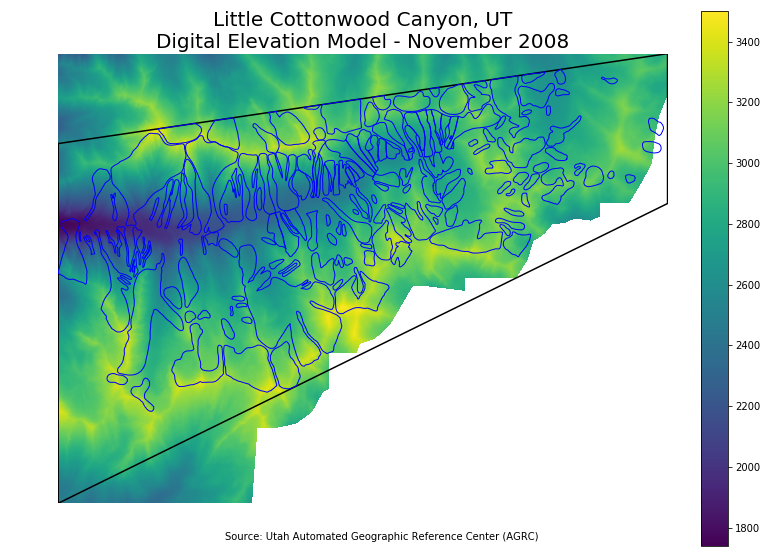

In [10]:
# Create DEM profile image
fig, ax = plt.subplots(figsize=(12, 12))
demplot = ax.imshow(image,
                    extent=cropped_spatial_extent,
                    cmap='viridis')
fig.colorbar(demplot, fraction=.04, anchor=(0.2, 0.3))
ax.set_axis_off()
ax.set_title(
    "Little Cottonwood Canyon, UT\nDigital Elevation Model - November 2008", fontsize=20)
fig.text(.5, .2, "Source: Utah Automated Geographic Reference Center (AGRC)", ha='center')
avalanche_extent_reproj.boundary.plot(ax=ax, color='black')
avalanche_clip_reproj.boundary.plot(ax=ax, color='blue', linewidth=1)
plt.show()

### Calculate and plot slope and aspect profile within study area

In [13]:
# Read in output file to calculate slope
output_file = os.path.join(modified_data_dir, "Final.tif")

dem_raw = rd.LoadGDAL(output_file, no_data=-9999.0)

# Process slope and aspect using richdem
slope = rd.TerrainAttribute(dem_raw, attrib='slope_degrees')

dem_aspect = rd.TerrainAttribute(dem_raw, attrib='aspect')

# Mask both arrays
slope_ma = np.ma.masked_where(slope == dem_raw.no_data,
                              slope,
                              copy=True)

aspect_ma = np.ma.masked_where(dem_aspect == dem_raw.no_data,
                               dem_aspect,
                               copy=True)

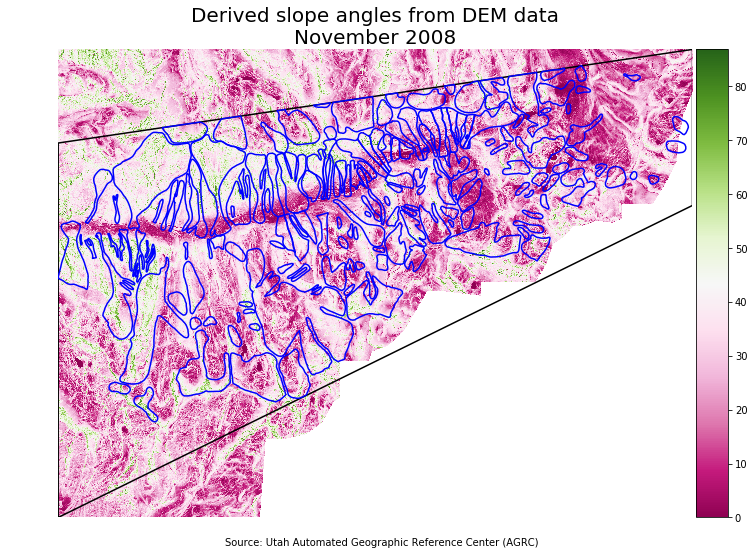

In [12]:
# Plot masked slope array
fig, ax = plt.subplots(figsize=(12, 12))
slopeplot = ax.imshow(slope_ma,
                      extent=cropped_spatial_extent,
                      cmap='PiYG')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(slopeplot, fraction=.04, cax=cax)
ax.set_axis_off()
ax.set_title("Derived slope angles from DEM data\nNovember 2008", fontsize=20)
fig.text(.5, .2, "Source: Utah Automated Geographic Reference Center (AGRC)", ha='center')
avalanche_extent_reproj.boundary.plot(ax=ax, color='black')
avalanche_clip_reproj.boundary.plot(ax=ax, color='blue')
plt.show()

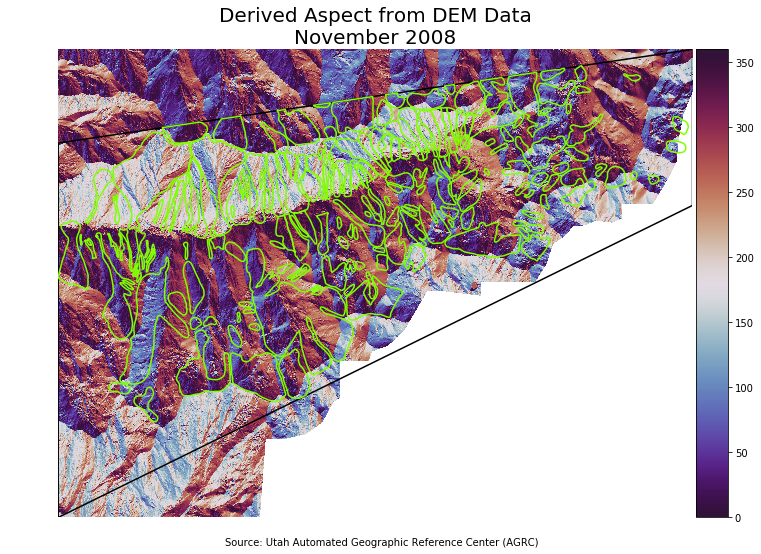

In [14]:
# Plot aspect profile
fig, ax = plt.subplots(figsize=(12, 12))
hillshade_plot = ax.imshow(aspect_ma,
                           extent=cropped_spatial_extent,
                           cmap='twilight_shifted')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(hillshade_plot, fraction=.04, cax=cax)
ax.set_axis_off()
ax.set_title("Derived Aspect from DEM Data\nNovember 2008", fontsize=20)
fig.text(.5, .2, "Source: Utah Automated Geographic Reference Center (AGRC)", ha='center')
avalanche_extent_reproj.boundary.plot(ax=ax, color='black')
avalanche_clip_reproj.boundary.plot(ax=ax, color='chartreuse')
plt.show()

### Resample slope and aspect arrays to calculate Avalanche Danger Score

In [15]:
# Define slope and aspect classification bins
slope_ma[slope_ma <= 25] = 1
slope_ma[(slope_ma > 25) & (slope_ma <= 35)] = 2
slope_ma[(slope_ma > 35) & (slope_ma <= 45)] = 3
slope_ma[(slope_ma > 45) & (slope_ma <= 55)] = 2
slope_ma[slope_ma > 55] = 1

aspect_ma[aspect_ma <= 45] = 3
aspect_ma[(aspect_ma > 45) & (aspect_ma <= 225)] = 2
aspect_ma[(aspect_ma > 225) & (aspect_ma <= 315)] = 1
aspect_ma[aspect_ma > 315] = 3

avy_danger_score = slope_ma*0.75 + aspect_ma*0.25

# Define avalanche danger thresholds
avy_danger_bins = [-np.inf, 1, 1.5, 2, 2.5, np.inf]

avy_danger_class = np.digitize(avy_danger_score, avy_danger_bins, right=True)

# Create color dictionary for danger score
nbr_colors = ["g", "yellowgreen", "peachpuff", "coral", "maroon"]
nbr_cmap = ListedColormap(nbr_colors)

In [16]:
# Avy site data prep to plot over danger score
data_fp = os.path.join('original', 'avi-stats')
input_csv_fn = glob(os.path.join(data_fp + '/site*.csv'))
avalanche_2011_df = pd.read_csv(input_csv_fn[0])
avalanche_2014_df = pd.read_csv(input_csv_fn[1])
avalanche_2017_df = pd.read_csv(input_csv_fn[2])

# Put the latitude and longitude for each year from the dataframe into numpy array
lats_lons_2011 = avalanche_2011_df.iloc[:, 7:9].values
lats_lons_2014 = avalanche_2014_df.iloc[:, 7:9].values
lats_lons_2017 = avalanche_2017_df.iloc[:, 7:9].values

### Plot Avalanche sites over Avalanche Danger profile

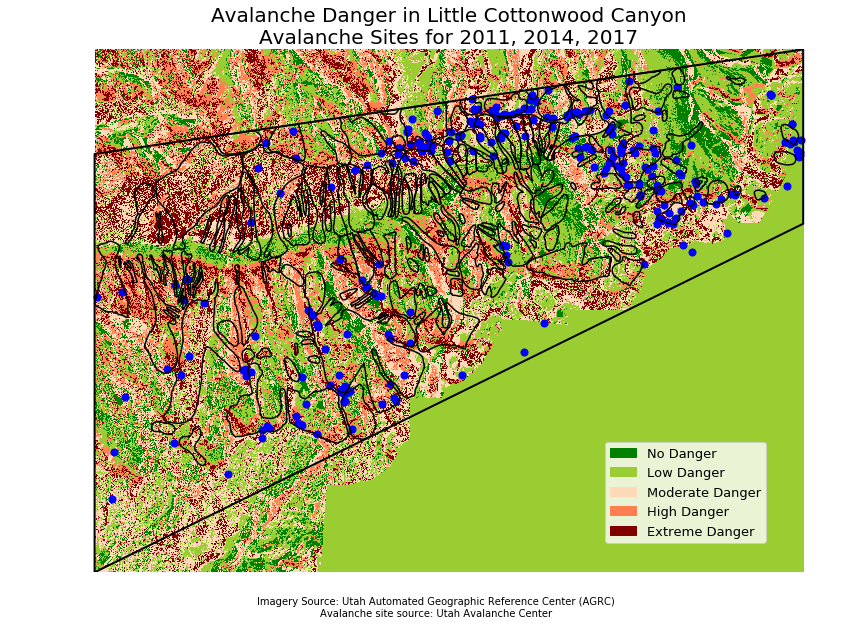

In [45]:
fig, ax = plt.subplots(figsize=(14, 14))

im = ax.imshow(avy_danger_class,
               extent=cropped_spatial_extent,
               cmap=nbr_cmap)

avalanche_extent_reproj.boundary.plot(ax=ax,
                                      edgecolor='black',
                                      linewidth=2)

avalanche_clip_reproj.boundary.plot(ax=ax, color='black', linewidth=1.5)

# Create legend
values = np.unique(avy_danger_class.ravel())
avy_cat_names = ["No Danger",
                 "Low Danger",
                 "Moderate Danger",
                 "High Danger",
                 "Extreme Danger"]
es.draw_legend(im,
               classes=values,
               titles=avy_cat_names,
               bbox=(0.7, 0.25))

# Loop through each 2011 lat/lon, convert to geopandas dataframe, and plot
for coord_2011 in lats_lons_2011:
    avi_site = np.array([[coord_2011[1], coord_2011[0]]]
                        )  # longtitude, latitude
    geometry = [Point(xy) for xy in avi_site]
    point_loc = gpd.GeoDataFrame(geometry,
                                 columns=['geometry'],
                                 crs={'init': 'epsg:4326'})
    point_loc.to_crs(epsg=26912).plot(ax=ax,
                                      markersize=50,
                                      color='blue')

# Loop through each 2014 lat/lon, convert to geopandas dataframe, and plot
for coord_2014 in lats_lons_2014:
    avi_site = np.array([[coord_2014[1], coord_2014[0]]]
                        )  # longtitude, latitude
    geometry = [Point(xy) for xy in avi_site]
    point_loc = gpd.GeoDataFrame(geometry,
                                 columns=['geometry'],
                                 crs={'init': 'epsg:4326'})
    point_loc.to_crs(epsg=26912).plot(ax=ax,
                                      markersize=50,
                                      color='blue')

# Loop through each 2017 lat/lon, convert to geopandas dataframe, and plot
for coord_2017 in lats_lons_2017:
    avi_site = np.array([[coord_2017[1], coord_2017[0]]]
                        )  # longtitude, latitude
    geometry = [Point(xy) for xy in avi_site]
    point_loc = gpd.GeoDataFrame(geometry,
                                 columns=['geometry'],
                                 crs={'init': 'epsg:4326'})
    point_loc.to_crs(epsg=26912).plot(ax=ax,
                                      markersize=50,
                                      color='blue')

blue_dot = Line2D([0], [0], marker='o', color='w', label='Avalanche site',
                  markerfacecolor='b', markersize=10)
#ax.legend(handles=[blue_dot], bbox_to_anchor=(0.75, 0.1))

ax.set_title("Avalanche Danger in Little Cottonwood Canyon\nAvalanche Sites for 2011, 2014, 2017",
             fontsize=20)

fig.text(.5, .2, "Imagery Source: Utah Automated Geographic Reference Center (AGRC)\nAvalanche site source: Utah Avalanche Center", ha='center')

ax.set_axis_off()

plt.show()

### Calculate zonal stats within avalanche paths

In [64]:
mean_danger = get_zonal_stats_dataframe(
    avalanche_clip_reproj, avy_danger_class, transform, 'mean')

avalanche_clip_reproj_danger_mask = mean_danger[mean_danger["mean"].notnull()]

avalanche_clip_reproj_danger_mask_update = avalanche_clip_reproj_danger_mask[
    avalanche_clip_reproj_danger_mask["mean"] > 1]

avalanche_clip_reproj_danger_mask_update["mean"].describe()

/anaconda3/envs/earth-analytics-python/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


count    165.000000
mean       3.177752
std        0.416956
min        1.792013
25%        2.929821
50%        3.182906
75%        3.425020
max        4.197136
Name: mean, dtype: float64

In [65]:
mean_slope = get_zonal_stats_dataframe(avalanche_clip_reproj, slope, transform, 'mean')

avalanche_clip_reproj_slope_mask = mean_slope[mean_slope["mean"].notnull()]

avalanche_clip_reproj_slope_mask_update = avalanche_clip_reproj_slope_mask[
    avalanche_clip_reproj_slope_mask["mean"] > 1]

avalanche_clip_reproj_slope_mask_update["mean"].describe()

/anaconda3/envs/earth-analytics-python/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


count    165.000000
mean      31.288749
std        6.031912
min       14.693191
25%       27.664602
50%       30.460401
75%       34.394386
max       50.706841
Name: mean, dtype: float64

In [67]:
mean_aspect = get_zonal_stats_dataframe(avalanche_clip_reproj, dem_aspect, transform, 'mean')

avalanche_clip_reproj_aspect_mask = mean_aspect[mean_aspect["mean"].notnull()]

avalanche_clip_reproj_aspect_mask_update = avalanche_clip_reproj_aspect_mask[
    avalanche_clip_reproj_aspect_mask["mean"] > 1]

avalanche_clip_reproj_aspect_mask_update["mean"].describe()

/anaconda3/envs/earth-analytics-python/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


count    165.000000
mean     194.955620
std       62.063464
min       61.869606
25%      155.567911
50%      189.274976
75%      244.888211
max      322.098736
Name: mean, dtype: float64

In [68]:
avalanche_clip_reproj_danger_mask_update

,NAME,SIZE_OF_SL,RETURN_INT,STARTING_Z,VERTICAL_F,DISTANCE_T,STARTING_1,Shape_Leng,Shape_Area,poly_no,geometry,mean
94,None,No Data,None,None,None,None,None,2200.465054,292120.345,1,"POLYGON ((448607.4000000009 4490637.5, 448596....",2.967233
79,None,No Data,None,None,None,None,None,1802.751019,105050.825,1,"POLYGON ((448489.3000000002 4491394.5, 448466....",2.154631
70,None,No Data,None,None,None,None,None,1205.955374,56191.875,1,"POLYGON ((448507.9000000006 4491832.999999999,...",3.384692
56,None,No Data,None,None,None,None,None,964.710696,49948.275,1,"POLYGON ((448924.7999999998 4492275, 448937.09...",2.655675
55,None,No Data,None,None,None,None,None,657.724097,18806.515,1,"POLYGON ((448522.0999999997 4492310.5, 448527....",2.363385
42,None,No Data,None,None,None,None,None,4196.049883,438018.935,1,"POLYGON ((449902.7000000002 4492813.5, 449922....",3.178843
47,None,No Data,None,None,None,None,None,1280.371924,78230.475,1,"POLYGON ((448947.2000000007 4492530.5, 448968 ...",2.576624
48,None,No Data,None,None,None,None,None,773.691256,43405.320,1,"POLYGON ((451841.5999999992 4492680.500000001,...",3.294215
46,None,No Data,None,None,None,None,None,1136.146705,86750.080,1,"POLYGON ((448610.5999999994 4492692.5, 448643....",3.246207
40,None,No Data,None,None,None,None,None,1725.621287,218388.775,1,"POLYGON ((450909.5000000005 4492527, 450870.70...",2.820871


### Plot Normalized Mean Danger within each avalanche path

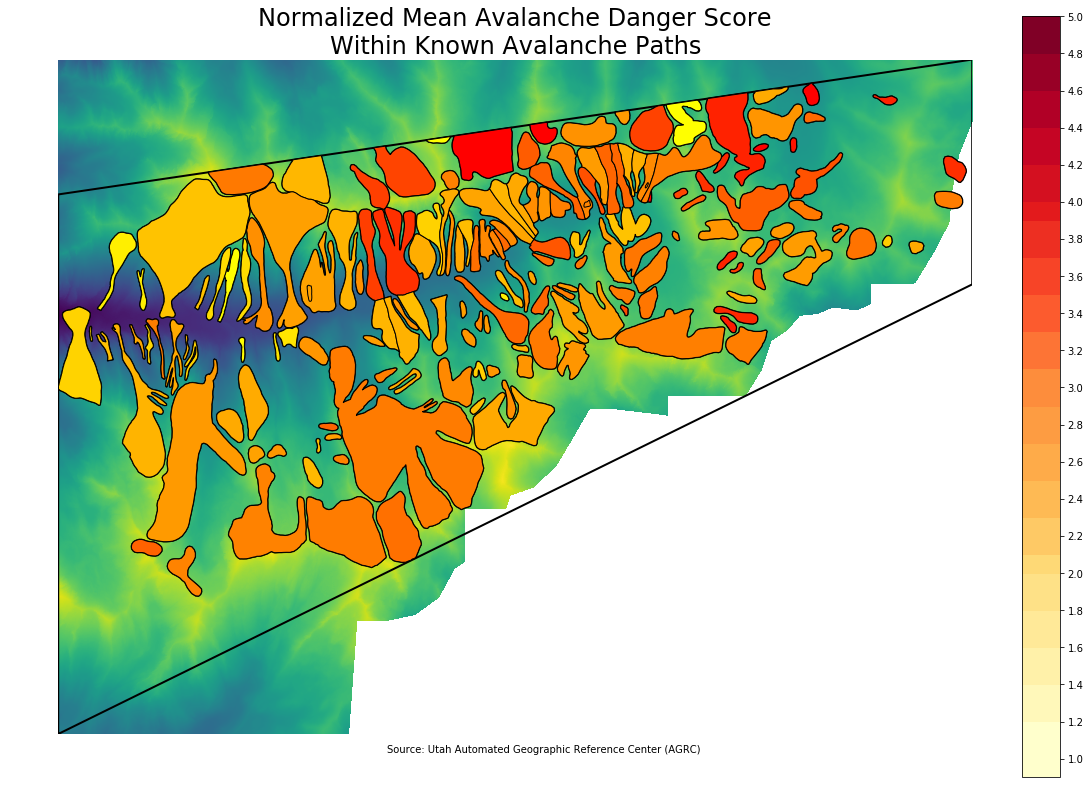

In [69]:
sf = shapefile.Reader(
    'original/vector/modified/Cottonwood_UT_paths_intersection/avalanche_intersection.shp')

fig, ax = plt.subplots(figsize=(18, 14))

im = ax.imshow(image,
               extent=cropped_spatial_extent)

avalanche_extent_reproj.boundary.plot(ax=ax,
                                      edgecolor='black',
                                      linewidth=2)

avalanche_clip_reproj.boundary.plot(ax=ax, color='black', linewidth=1.5)

# get list of field names, pull out appropriate index
# fieldnames of interest: Shape_Area for us.
fld = sf.fields[1:]
field_names = [field[0] for field in fld]
fld_name = 'Shape_Area'
fld_ndx = field_names.index(fld_name)

# loop over records, track global min/max
maxmean = -9e20
minmean = 9e20

for shapeRec in sf.iterShapeRecords():
    # pull out shape geometry and records
    shape = shapeRec.shape
    rec = shapeRec.record

    area = rec[fld_ndx]
    # minrec=np.min((minrec,rec[fld_ndx]))
    color_src_2 = avalanche_clip_reproj_danger_mask_update[
        avalanche_clip_reproj_danger_mask_update.Shape_Area == area]
    maxmean = np.max((maxmean, color_src_2["mean"]))
    minmean = np.min((minmean, color_src_2["mean"]))

    # define polygon fill color (facecolor) RGB values:
    R = 1
    G = (color_src_2["mean"]-minmean)/(maxmean-minmean)
    G = G * (G <= 1) + 1.0 * (G > 1.0)
    B = 0

    # check number of parts
    nparts = len(shape.parts)  # total parts
    if nparts == 1:
        polygon = Polygon(shape.points)
        patch = PolygonPatch(polygon, facecolor=[R, G, B], alpha=1.0, zorder=2)
        ax.add_patch(patch)

    else:  # loop over parts of each shape, plot separately
        for ip in range(nparts):  # loop over parts, plot separately
            i0 = shape.parts[ip]
            if ip < nparts-1:
                i1 = shape.parts[ip+1]-1
            else:
                i1 = len(shape.points)

            polygon = Polygon(shape.points[i0:i1+1])
            patch = PolygonPatch(polygon, facecolor=[
                                 R, G, B], alpha=1.0, zorder=2)
            ax.add_patch(patch)

N = 21
cmap = plt.get_cmap('YlOrRd', N)

norm = mpl.colors.Normalize(vmin=1, vmax=5)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, ticks=np.linspace(1, 5, N),
             boundaries=np.arange(0.9, 5.1, .1), fraction=0.04)

ax.set_title("Normalized Mean Avalanche Danger Score\nWithin Known Avalanche Paths",
             fontsize=24)

fig.text(.5, .15, "Source: Utah Automated Geographic Reference Center (AGRC)", ha='center')

ax.set_axis_off()

ax.autoscale_view()
plt.show()